In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'LiH'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-6g'


### Get Hamiltonian
Hamilt = Hamiltonian_PySCF(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='BK')
### HAMILTONIAN end
QubitHamiltonian

(-3.98997241818937+0j) [] +
(0.04037460325642923+0j) [X0 X1 X2] +
(-0.0031615876042056738+0j) [X0 X1 X2 X3 Y7 Y11] +
(0.0016204769263754707+0j) [X0 X1 X2 Y3 Y5] +
(0.0036508502556760435+0j) [X0 X1 X2 Z3] +
(0.0018998726581461486+0j) [X0 X1 Z2 X3 Y7 Z9 Y10 X11] +
(0.004695260540246226+0j) [X0 X1 Z2 Y3 Y4 X5] +
(-0.0012113027134831413+0j) [X0 X1 X3 X4 Y7 Y11] +
(0.0010441957704833786+0j) [X0 X1 X3 Y4 Y5 Z6 Z7] +
(0.0012113027134831413+0j) [X0 X1 X3 Y4 Z5 Y7 Z9 Z10 X11] +
(0.0025594391105538085+0j) [X0 X1 X3 Z4 Y5 Y6 Z7] +
(6.648581206869598e-05+0j) [X0 X1 X3 Z4 Z5 Y7 Z9 Y10 X11] +
(0.0012777885255518373+0j) [X0 X1 X3 Z4 Y7 Z9 Y10 X11] +
(0.0009618499558327639+0j) [X0 X1 X3 X6 Y7 Y11] +
(-0.0001567017221039954+0j) [X0 X1 X3 Z6 Y7 Z9 Y10 X11] +
(0.0009618499558327638+0j) [X0 X1 X3 Y7 X8 Y11] +
(-0.0009618499558327638+0j) [X0 X1 X3 Y7 Y8 Z10 X11] +
(-0.00015670172210399707+0j) [X0 X1 X3 Y7 Z8 Z9 Y10 X11] +
(0.0008051482337287667+0j) [X0 X1 X3 Y7 Z8 Y10 X11] +
(0.015294910119291617+0j) [X0 X

In [2]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

print('JW ground state = ', ansatz_obj.Get_JW_HF_state_in_OCC_basis())
print('BK ground state = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())

JW ground state =  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
BK ground state =  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The LiH ground state under JW is:

$$|\psi \rangle_{HF}^{ground} = | 1 1 1 1 \:  0 0 0 0 0 0 0 0 \rangle$$

and under BK is:

$$|\psi \rangle_{HF}^{ground} = | 1 0 1 0 0 0 0 0 0 0 0 0 \rangle$$

### Look at NATURAL orbital occupations!

In [3]:
NOON_spins_combined, NMO_basis = Hamilt.Get_NOON()
##
Hamilt.Get_CCSD_Amplitudes()

NOON_spins_combined

print(print(np.around(np.diag(NOON_spins_combined), 5)))

[[1.99992e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.96765e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 2.71800e-02 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 2.59000e-03 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.59000e-03 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e-05]]
None


This shows that orbitals (0,1) are nearly always FILLED
and
orbitals (10,11) are nearly always UNILLED!

In paper: PHYS. REV. X, **8**, 031022 (2018)
- active space chosen to be **spatial orbitals** 1-4 (aka spin orbital indices (2,3),(4,5),(6,7),(8,9)
- aka to simply problem here orbitals (8,9) also assumed to be empty!


In [4]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)



Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)

Sec_Quant_CC_ops_ia

[-1.0 [0^ 4] +
 1.0 [4^ 0],
 -1.0 [0^ 6] +
 1.0 [6^ 0],
 -1.0 [0^ 8] +
 1.0 [8^ 0],
 -1.0 [0^ 10] +
 1.0 [10^ 0],
 -1.0 [2^ 4] +
 1.0 [4^ 2],
 -1.0 [2^ 6] +
 1.0 [6^ 2],
 -1.0 [2^ 8] +
 1.0 [8^ 2],
 -1.0 [2^ 10] +
 1.0 [10^ 2],
 -1.0 [1^ 5] +
 1.0 [5^ 1],
 -1.0 [1^ 7] +
 1.0 [7^ 1],
 -1.0 [1^ 9] +
 1.0 [9^ 1],
 -1.0 [1^ 11] +
 1.0 [11^ 1],
 -1.0 [3^ 5] +
 1.0 [5^ 3],
 -1.0 [3^ 7] +
 1.0 [7^ 3],
 -1.0 [3^ 9] +
 1.0 [9^ 3],
 -1.0 [3^ 11] +
 1.0 [11^ 3]]

# Remove fermionic terms we are NOT taking into account

In [5]:
ansatz_obj = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

In [6]:
indices_to_KEEP = [2,3,4,5,6,7]

NEW_Sec_Quant_CC_ops_ia, NEW_Sec_Quant_CC_ops_ijab, theta_ia, theta_ijab = ansatz_obj.Reduced_ia_ijab_terms(
                                         Hamilt.molecule.n_qubits, 
                                         Hamilt.molecule.n_electrons, 
                                         indices_to_KEEP)
NEW_Sec_Quant_CC_ops_ia

[-1.0 [2^ 4] +
 1.0 [4^ 2],
 -1.0 [2^ 6] +
 1.0 [6^ 2],
 -1.0 [3^ 5] +
 1.0 [5^ 3],
 -1.0 [3^ 7] +
 1.0 [7^ 3]]

In [7]:
NEW_Sec_Quant_CC_ops_ijab

[-1.0 [2^ 3^ 4 5] +
 1.0 [5^ 4^ 3 2],
 -1.0 [2^ 3^ 4 7] +
 1.0 [7^ 4^ 3 2],
 -1.0 [2^ 3^ 6 7] +
 1.0 [7^ 6^ 3 2]]

In [8]:
# REDUCTION
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(
                        NEW_Sec_Quant_CC_ops_ia,
                        NEW_Sec_Quant_CC_ops_ijab,
                        transformation='BK')
# Qubit_Op_list_Second_Quant_CC_Ops_ijab

In [9]:
print('finding DOUBLE e- operators only acted on by I or Z')
print('')
print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

indices_to_Remove_ijab = ansatz_obj.Find_Qubits_only_acted_on_by_I_or_Z(Qubit_Op_list_Second_Quant_CC_Ops_ijab)
print('')
print('qubit indices:', indices_to_Remove_ijab, 'only acted on by I or Z')

finding DOUBLE e- operators only acted on by I or Z

[0.125j [Z1 X2 Z3 Y4] +
0.125j [Z1 X2 Z3 Y4 Z5] +
-0.125j [Z1 Y2 Z3 X4] +
-0.125j [Z1 Y2 Z3 X4 Z5] +
0.125j [X2 Y4] +
0.125j [X2 Y4 Z5] +
-0.125j [Y2 X4] +
-0.125j [Y2 X4 Z5], 0.125j [Z1 X2 Z3 X4 Y5 Z6] +
0.125j [Z1 X2 Y4 X5 Z7] +
0.125j [Z1 Y2 Z3 Y4 Y5 Z6] +
-0.125j [Z1 Y2 X4 X5 Z7] +
0.125j [X2 Z3 Y4 X5 Z7] +
0.125j [X2 X4 Y5 Z6] +
-0.125j [Y2 Z3 X4 X5 Z7] +
0.125j [Y2 Y4 Y5 Z6], 0.125j [Z1 X2 Z3 Y6] +
0.125j [Z1 X2 Z5 Y6 Z7] +
-0.125j [Z1 Y2 Z3 X6] +
-0.125j [Z1 Y2 Z5 X6 Z7] +
0.125j [X2 Z3 Z5 Y6 Z7] +
0.125j [X2 Y6] +
-0.125j [Y2 Z3 Z5 X6 Z7] +
-0.125j [Y2 X6]]

qubit indices: [ 0  1  3  7  8  9 10 11] only acted on by I or Z


In [10]:
print('finding SINGLE e- operators only acted on by I or Z')
print('')
print(Qubit_Op_list_Second_Quant_CC_Ops_ia)

indices_to_Remove_ia = ansatz_obj.Find_Qubits_only_acted_on_by_I_or_Z(Qubit_Op_list_Second_Quant_CC_Ops_ia)
print('')
print('qubit indices:', indices_to_Remove_ia, 'only acted on by I or Z')

finding SINGLE e- operators only acted on by I or Z

[0.5j [Z1 X2 Y3 X4] +
0.5j [Z1 Y2 Y3 Y4], 0.5j [Z1 X2 Y3 Z5 X6] +
0.5j [Z1 Y2 Y3 Z5 Y6], 0.5j [Z1 Z2 Y3 Z4 X5] +
-0.5j [X3 Y5], 0.5j [Z1 Z2 Y3 Z5 Z6] +
-0.5j [Y3 Z7]]

qubit indices: [ 0  1  7  8  9 10 11] only acted on by I or Z


#### find overlap of allowed indices to remove

In [11]:
indices_to_Remove = list(set(indices_to_Remove_ijab).intersection(indices_to_Remove_ia))
indices_to_Remove

[0, 1, 7, 8, 9, 10, 11]

In [12]:
# only Z terms in H remain!!!!!
from openfermion import qubit_operator_sparse
from openfermion.ops import QubitOperator

MAT = qubit_operator_sparse(QubitOperator('Z0 X1', 1))

zero = np.array([[1],[0]])
one = np.array([[0],[1]])

state = reduce(np.kron, [one, zero])

state.conj().transpose().dot(MAT.todense().dot(state))

matrix([[0.+0.j]])

### Can remove these terms from Hamiltonian

In [13]:
reduced_Qubit_Hamiltonian = ansatz_obj.Remove_indices_from_Hamiltonian(indices_to_Remove)
reduced_Qubit_Hamiltonian

(-7.27686951249772+0j) [] +
(0.009344683608046807+0j) [X2 X3 X4 X5] +
(-0.0002763469689739084+0j) [X2 X3 Y4 Y5 Z6] +
(0.004836443728006642+0j) [X2 X3 Z4 Y5 Y6] +
(0.00032184554262277735+0j) [X2 Y3 X4 Y5] +
(0.004739070747198821+0j) [X2 Y3 Y4 X5] +
(0.004560096759032734+0j) [X2 Y3 Y4 X5 Z6] +
(-0.004836443728006642+0j) [X2 Y3 Y5 X6] +
(0.0022366866582381874+0j) [X2 Z3 X4] +
(0.006727778833176454+0j) [X2 Z3 Z5 X6] +
(0.006727778833176454+0j) [X2 Z3 X6] +
(0.0022366866582381874+0j) [X2 X4 Z5] +
(0.0002763469689739084+0j) [Y2 X3 X4 Y5 Z6] +
(0.009344683608046807+0j) [Y2 X3 Y4 X5] +
(-0.004836443728006642+0j) [Y2 X3 Z4 Y5 X6] +
(-0.004739070747198821+0j) [Y2 Y3 X4 X5] +
(-0.004560096759032734+0j) [Y2 Y3 X4 X5 Z6] +
(0.00032184554262277735+0j) [Y2 Y3 Y4 Y5] +
(-0.004836443728006642+0j) [Y2 Y3 Y5 Y6] +
(0.0022366866582381874+0j) [Y2 Z3 Y4] +
(0.006727778833176454+0j) [Y2 Z3 Z5 Y6] +
(0.006727778833176454+0j) [Y2 Z3 Y6] +
(0.0022366866582381874+0j) [Y2 Y4 Z5] +
(0.026230489264680232+0j) [Z2] +

### Can remove these terms from Anstz

In [14]:
reduced_ijab_CC = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab,
                                                             indices_to_Remove)
reduced_ijab_CC

[0.125j [X2 Z3 Y4] +
 0.125j [X2 Z3 Y4 Z5] +
 0.125j [X2 Y4] +
 0.125j [X2 Y4 Z5] +
 -0.125j [Y2 Z3 X4] +
 -0.125j [Y2 Z3 X4 Z5] +
 -0.125j [Y2 X4] +
 -0.125j [Y2 X4 Z5],
 0.125j [X2 Z3 X4 Y5 Z6] +
 0.125j [X2 Z3 Y4 X5] +
 0.125j [X2 X4 Y5 Z6] +
 0.125j [X2 Y4 X5] +
 -0.125j [Y2 Z3 X4 X5] +
 0.125j [Y2 Z3 Y4 Y5 Z6] +
 -0.125j [Y2 X4 X5] +
 0.125j [Y2 Y4 Y5 Z6],
 0.125j [X2 Z3 Z5 Y6] +
 0.125j [X2 Z3 Y6] +
 0.125j [X2 Z5 Y6] +
 0.125j [X2 Y6] +
 -0.125j [Y2 Z3 Z5 X6] +
 -0.125j [Y2 Z3 X6] +
 -0.125j [Y2 Z5 X6] +
 -0.125j [Y2 X6]]

In [15]:
reduced_ia_CC = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ia,
                                                             indices_to_Remove)
reduced_ia_CC

[0.5j [X2 Y3 X4] +
 0.5j [Y2 Y3 Y4],
 0.5j [X2 Y3 Z5 X6] +
 0.5j [Y2 Y3 Z5 Y6],
 0.5j [Z2 Y3 Z4 X5] +
 -0.5j [X3 Y5],
 0.5j [Z2 Y3 Z5 Z6] +
 -0.5j [Y3]]

# NEXT need to re-label everything

In [16]:
# Relabelling H
relabel_dict, relabelled_reduced_Qubit_Hamiltonian = ansatz_obj.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)

print('qubit relabelling dict = ', relabel_dict)

relabelled_reduced_Qubit_Hamiltonian

qubit relabelling dict =  {2: 0, 3: 1, 4: 2, 5: 3, 6: 4}


(-7.27686951249772+0j) [] +
(0.009344683608046807+0j) [X0 X1 X2 X3] +
(-0.0002763469689739084+0j) [X0 X1 Y2 Y3 Z4] +
(0.004836443728006642+0j) [X0 X1 Z2 Y3 Y4] +
(0.00032184554262277735+0j) [X0 Y1 X2 Y3] +
(0.004739070747198821+0j) [X0 Y1 Y2 X3] +
(0.004560096759032734+0j) [X0 Y1 Y2 X3 Z4] +
(-0.004836443728006642+0j) [X0 Y1 Y3 X4] +
(0.0022366866582381874+0j) [X0 Z1 X2] +
(0.006727778833176454+0j) [X0 Z1 Z3 X4] +
(0.006727778833176454+0j) [X0 Z1 X4] +
(0.0022366866582381874+0j) [X0 X2 Z3] +
(0.0002763469689739084+0j) [Y0 X1 X2 Y3 Z4] +
(0.009344683608046807+0j) [Y0 X1 Y2 X3] +
(-0.004836443728006642+0j) [Y0 X1 Z2 Y3 X4] +
(-0.004739070747198821+0j) [Y0 Y1 X2 X3] +
(-0.004560096759032734+0j) [Y0 Y1 X2 X3 Z4] +
(0.00032184554262277735+0j) [Y0 Y1 Y2 Y3] +
(-0.004836443728006642+0j) [Y0 Y1 Y3 Y4] +
(0.0022366866582381874+0j) [Y0 Z1 Y2] +
(0.006727778833176454+0j) [Y0 Z1 Z3 Y4] +
(0.006727778833176454+0j) [Y0 Z1 Y4] +
(0.0022366866582381874+0j) [Y0 Y2 Z3] +
(0.026230489264680232+0j) [Z0] +

In [17]:
# Relabelling ANSATZ
relabelled_reduced_ia_CC = ansatz_obj.Re_label_CC_qubit_operators(relabel_dict, reduced_ia_CC)
relabelled_reduced_ijab_CC = ansatz_obj.Re_label_CC_qubit_operators(relabel_dict, reduced_ijab_CC)
relabelled_reduced_ijab_CC

[0.125j [X0 Z1 Y2] +
 0.125j [X0 Z1 Y2 Z3] +
 0.125j [X0 Y2] +
 0.125j [X0 Y2 Z3] +
 -0.125j [Y0 Z1 X2] +
 -0.125j [Y0 Z1 X2 Z3] +
 -0.125j [Y0 X2] +
 -0.125j [Y0 X2 Z3],
 0.125j [X0 Z1 X2 Y3 Z4] +
 0.125j [X0 Z1 Y2 X3] +
 0.125j [X0 X2 Y3 Z4] +
 0.125j [X0 Y2 X3] +
 -0.125j [Y0 Z1 X2 X3] +
 0.125j [Y0 Z1 Y2 Y3 Z4] +
 -0.125j [Y0 X2 X3] +
 0.125j [Y0 Y2 Y3 Z4],
 0.125j [X0 Z1 Z3 Y4] +
 0.125j [X0 Z1 Y4] +
 0.125j [X0 Z3 Y4] +
 0.125j [X0 Y4] +
 -0.125j [Y0 Z1 Z3 X4] +
 -0.125j [Y0 Z1 X4] +
 -0.125j [Y0 Z3 X4] +
 -0.125j [Y0 X4]]

## Find New input state

In [18]:
print('old input = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())
print('BUT following indices removed:', indices_to_Remove)
ansatz_obj.New_BK_HF_state(indices_to_Remove)

old input =  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
BUT following indices removed: [0, 1, 7, 8, 9, 10, 11]


array([1., 0., 0., 0., 0.])

# Find what new FCI energy is

In [19]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(relabelled_reduced_Qubit_Hamiltonian)


from scipy.linalg import eig
eig_values, eig_vectors = eig(new_Molecular_H_MATRIX.todense())
new_FCI_Energy = min(eig_values)


print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', Hamilt.molecule.fci_energy)

new_FCI =  (-7.8596897945789355+0j) VS old FCI: -7.875652564927905


# Simulating

### Ansatz circuit 

In [20]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ia_CC))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ijab_CC))]
#combined_ia_ijab_theta_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

In [21]:
new_BK_state = ansatz_obj.New_BK_HF_state(indices_to_Remove)


UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_BK_state,
                                     relabelled_reduced_ia_CC, 
                                     relabelled_reduced_ijab_CC)

UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

┌─────────┐                 ┌──────────┐
0: ───X───H──────────@─────────────────────────@───H───────────Rx(0.5π)───@─────────────────────────@───────────Rx(-0.5π)───H──────────@────────────────────────────────@──────────H───────────Rx(0.5π)───@────────────────────────────────────────@───Rx(-0.5π)──────────────@─────────────────────────────────@──────────────────────────────────────────────────────────────────────@─────────────────────────────────@───H────────────────────@────────────────────────────@────H───────────H──────────@─────────────────────────@───────────H───Rx(0.5π)───@────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────@───Rx(-0.5π)───H───@─────────────────────────@───H───────────H──────────@────────────────────────────────────────@───────────H───H───@─────────────────────────────────@───────────H──────────H───@─────────────────────────────────────────────────@──────────H──────────Rx(0.5π)───@─────────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───H──────────@─────────────────────────────────@───────────H──────────H───@─────────────────────────@───H───────────H───@─────────────────@───H───────────H──────────@─────────────────────────@───────────H───Rx(0.5π)───@────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───H───@─────────────────────────────────────────@──────────H───H───@─────────────────────────@───────────H───
                     │                         │                          │                         │                                  │                                │                                 │                                        │                          │                                 │                                                                      │                                 │                        │                            │                           │                         │                          │                │                          │                        │                          │                        │                          │                                │                   │                         │                          │                                        │                   │                                 │                          │                                                 │                                │                                 │                                  │                                                        │                                  │                                │                          │                        │                          │                                 │                          │                         │                   │                 │                          │                         │                          │                │                          │                        │                          │                                │                          │                        │                   │                                         │                  │                         │
1: ───I───Rx(0.5π)───X───@─────────────────@───X───Rx(-0.5π)───Rx(0.5π)───X───@─────────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───X───@────────────────────────@───X──────────Rx(-0.5π)───Rx(0.5π)───X───@────────────────────────@───────────X───Rx(-0.5π)───Rx(0.5π)───X───@─────────────────────────@───X──────────Rx(-0.5π)───H───@────────────────@───H───────────Rx(0.5π)───X───@──────────────────────

### Calc ENERGY 

In [22]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(relabelled_reduced_Qubit_Hamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 62/62 [00:00<00:00, 336.96it/s]


{0: [(-7.27686951249772+0j) []],
 1: [(0.07828114149315554+0j) [Z1 Z3]],
 2: [(0.05937749358221966+0j) [Z0 Z1 Z2 Z3],
  (0.006727778833176454+0j) [Y0 Z1 Z3 Y4],
  (-0.004836443728006642+0j) [Y0 X1 Z2 Y3 X4],
  (0.010595797757054028+0j) [Z1 X2 Z3 X4],
  (-0.004836443728006641+0j) [Z0 X1 X2 Y3 Y4]],
 3: [(0.05937749358221966+0j) [Z0 Z2],
  (0.006727778833176454+0j) [X0 Z1 Z3 X4],
  (0.004836443728006641+0j) [Z0 X1 Y2 Y3 X4],
  (0.010595797757054028+0j) [Z1 Y2 Z3 Y4],
  (0.004836443728006642+0j) [X0 X1 Z2 Y3 Y4]],
 4: [(-0.14432019122698886+0j) [Z1 Z3 Z4],
  (0.006727778833176454+0j) [X0 Z1 X4],
  (0.010595797757054028+0j) [Y2 Z3 Y4],
  (-0.004836443728006641+0j) [X1 X2 X3 X4],
  (-0.004836443728006642+0j) [Y0 Y1 Y3 Y4]],
 5: [(-0.14432019122698875+0j) [Z4],
  (0.006727778833176454+0j) [Y0 Z1 Y4],
  (0.010595797757054028+0j) [X2 Z3 X4],
  (-0.004836443728006641+0j) [X1 Y2 X3 Y4],
  (-0.004836443728006642+0j) [X0 Y1 Y3 X4]],
 6: [(0.07521726040101404+0j) [Z0 Z1 Z4],
  (0.004739070747198816

In [23]:
from quchem.LCU_method import *

In [24]:
N_QUBITS = Hamilt.molecule.n_qubits - len(indices_to_Remove)

def GIVE_ENERGY_lin_alg(theta_ia_ijab_combined):
    
    theta_ia = theta_ia_ijab_combined[:len(relabelled_reduced_ia_CC)]
    theta_ijab=theta_ia_ijab_combined[len(relabelled_reduced_ia_CC):]
    
    ansatz_cirq_circuit = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    
    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(
                 anti_commuting_sets,
                 ansatz_cirq_circuit,
                 N_QUBITS,                     # <--- NOTE THIS
                 N_indices_dict=None) 
    
    energy = VQE_exp_LCU_lin_alg.Calc_Energy()
    
    return energy.real

In [26]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ia_CC))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ijab_CC))]
combined_ia_ijab_theta_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

GIVE_ENERGY_lin_alg(combined_ia_ijab_theta_random_input)
# GIVE_ENERGY_lin_alg([0.02899934, 4.8385951,  0.69773897, 2.99774031, 3.65637243, 0.01091735, 1.5881969 ])

-7.530187596120401

## Optimizing

In [27]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

In [28]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

0: Input_to_Funct: [2.98591575 4.00140738 3.07175971 5.49262935 5.1040768  2.39030667
 1.46273054]: Output: -7.625894772842862
1: Input_to_Funct: [3.08417739 4.10099315 3.00008941 5.39307296 5.18086083 2.46242867
 1.36536989]: Output: -7.696404499163636
2: Input_to_Funct: [3.17345609 4.19835395 3.02171137 5.2956008  5.26563616 2.54457018
 1.29332417]: Output: -7.739629110069347
3: Input_to_Funct: [3.23739592 4.29078863 3.07506736 5.20269607 5.35578834 2.6331083
 1.28718431]: Output: -7.765450143797928
4: Input_to_Funct: [3.26393064 4.37609311 3.13770621 5.1159234  5.44900664 2.72512046
 1.32400575]: Output: -7.785896229395875
5: Input_to_Funct: [3.25886157 4.45341777 3.1872958  5.03512434 5.54120174 2.81591705
 1.38216326]: Output: -7.8054802198659115
6: Input_to_Funct: [3.23312477 4.52316551 3.20215943 4.95919272 5.62821532 2.90096921
 1.45218415]: Output: -7.826265590410216
7: Input_to_Funct: [3.19550117 4.58655791 3.18770031 4.88708575 5.7074424  2.97789814
 1.52850654]: Output: -7.

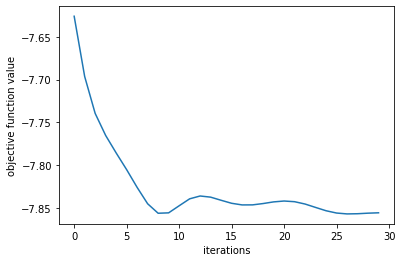

In [29]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg,
                   combined_ia_ijab_theta_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(30)
GG.plot_convergence()
plt.show()

## STANDARD

In [30]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(relabelled_reduced_Qubit_Hamiltonian)

In [31]:
def Calc_E_from_full_H(theta_ia_ijab_combined):
    theta_ia = theta_ia_ijab_combined[:len(relabelled_reduced_ia_CC)]
    theta_ijab=theta_ia_ijab_combined[len(relabelled_reduced_ia_CC):]
                   
    UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)
                   
                   
    input_state = reduce(np.kron, [np.array([[1],[0]]) for _ in range(len(UCCSD_ansatz_Q_Circ.all_qubits()))])
    
    UCC_op = UCCSD_ansatz_Q_Circ.unitary()
    
    ansatz_state_ket = UCC_op.dot(input_state)
    ansatz_state_bra = ansatz_state_ket.transpose().conj()
    
    energy = ansatz_state_bra.dot(new_Molecular_H_MATRIX.todense().dot(ansatz_state_ket))
    return energy.item(0)
  
    

In [32]:
def calc_gradient_ADAM_full_H(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = Calc_E_from_full_H(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = Calc_E_from_full_H(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

0: Input_to_Funct: [2.98591575+4.91148748e-39j 4.00140738-2.96570488e-39j
 3.07175971+7.87154401e-38j 5.49262935+0.00000000e+00j
 5.1040768 +6.85449598e-35j 2.39030667+1.62064252e-33j
 1.46273054-2.04083418e-38j]: Output: (-7.625894772842924+0j)
1: Input_to_Funct: [3.08417739+9.10364087e-33j 4.10099315+8.76933502e-33j
 3.00008941-6.49361807e-31j 5.39307296-1.74764495e-33j
 5.18086083+1.97598567e-31j 2.46242867+1.86530191e-30j
 1.36536989-2.71091376e-32j]: Output: (-7.6964044991637+0j)
2: Input_to_Funct: [3.17345609-6.20652823e-32j 4.19835395+1.69195577e-32j
 3.02171137-9.42637808e-31j 5.2956008 -8.46878256e-33j
 5.26563616+2.58428559e-31j 2.54457018+2.47771074e-30j
 1.29332417-1.85082381e-31j]: Output: (-7.739629110069422+1.9721522630525295e-31j)
3: Input_to_Funct: [3.23739592-1.49326084e-31j 4.29078863+2.01076291e-32j
 3.07506736-1.07039564e-30j 5.20269607+6.71291667e-33j
 5.35578834+2.86522848e-31j 2.6331083 +2.83613452e-30j
 1.28718431-5.16083679e-31j]: Output: (-7.765450143797983-9

/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


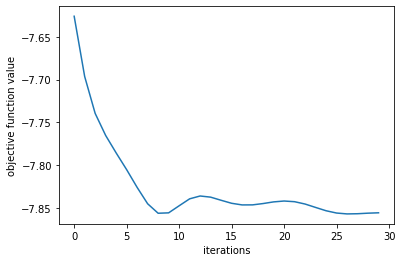

In [33]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(Calc_E_from_full_H,
                   combined_ia_ijab_theta_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM_full_H,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(30)
GG.plot_convergence()
plt.show()

### CONJ

In [34]:
from quchem.Unitary_partitioning import *

In [35]:
def GIVE_ENERGY_lin_alg_CONJ(theta_ia_ijab_combined):
    
    theta_ia = theta_ia_ijab_combined[:len(relabelled_reduced_ia_CC)]
    theta_ijab=theta_ia_ijab_combined[len(relabelled_reduced_ia_CC):]
    
    ansatz_cirq_circuit = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    
    VQE_exp_CONJ_lin_alg = VQE_Experiment_Conj_UP_lin_alg(
                 anti_commuting_sets,
                 ansatz_cirq_circuit,
                 S_key_dict=None)

    
    energy = VQE_exp_CONJ_lin_alg.Calc_Energy()
    
    return energy

GIVE_ENERGY_lin_alg_CONJ(combined_ia_ijab_theta_random_input)

-7.5301875961204

In [36]:
def calc_gradient_ADAM_CONJ(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg_CONJ(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg_CONJ(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

0: Input_to_Funct: [2.98591575 4.00140738 3.07175971 5.49262935 5.1040768  2.39030667
 1.46273054]: Output: -7.625894772842861
1: Input_to_Funct: [3.08417739 4.10099315 3.00008941 5.39307296 5.18086083 2.46242867
 1.36536989]: Output: -7.696404499163641
2: Input_to_Funct: [3.17345609 4.19835395 3.02171137 5.2956008  5.26563616 2.54457018
 1.29332417]: Output: -7.739629110069352
3: Input_to_Funct: [3.23739592 4.29078863 3.07506736 5.20269607 5.35578834 2.6331083
 1.28718431]: Output: -7.765450143797936
4: Input_to_Funct: [3.26393064 4.37609311 3.13770621 5.1159234  5.44900664 2.72512046
 1.32400575]: Output: -7.785896229395882
5: Input_to_Funct: [3.25886157 4.45341777 3.1872958  5.03512434 5.54120174 2.81591705
 1.38216326]: Output: -7.805480219865919
6: Input_to_Funct: [3.23312477 4.52316551 3.20215943 4.95919272 5.62821532 2.90096921
 1.45218415]: Output: -7.826265590410223
7: Input_to_Funct: [3.19550117 4.58655791 3.18770031 4.88708575 5.7074424  2.97789814
 1.52850654]: Output: -7.8

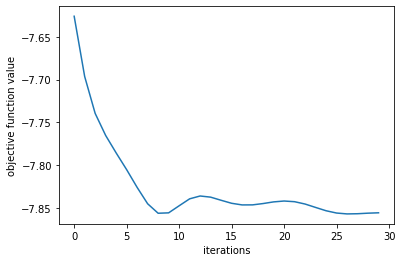

In [37]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg_CONJ,
                   combined_ia_ijab_theta_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM_CONJ,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(30)
GG.plot_convergence()
plt.show()

In [ ]:
fasdfads

In [ ]:
## checking R operator!

def tt(anti_commuting_set, N_index):
    """

    Function gets the R operator as a linear combination of unitary operators.

    First the X operator is found:
    X = i ∑_{k=0} 𝛿_{k} P_{kn}

    R has the definition:
    𝑅=exp(−𝑖𝛼X/2)=cos(𝛼/2)𝟙−𝑖sin(𝛼/2)X
    this is used to build R

    ###
     anti_set = ∑_{i=0} 𝛼_{i} P_{i}.
     normalised = 𝛾_{𝑙} ∑_{i=0} 𝛽_{i} P_{i}... where ∑_{i=0} 𝛽_{i}^{2} =1

     the 𝛽n Pn is then removed and set normalised again:
     H_{n_1} =  Ω_{𝑙} ∑_{k=0} 𝛿_{k} P_{k} ... where k!=n

    then:
    X = i ∑_{k=0} 𝛿_{k} P_{k} P_{n} = i ∑_{k=0} 𝛿_{k} P_{kn}
    ####
    Paper also defines
    H_n = cos(𝜙_{n-1}) Pn + sin(𝜙_{n-1}) H_{n_1 }

    currently have:
    H_{n}/𝛾_{𝑙} = 𝛽n Pn +  Ω_{𝑙} H_{n_1}

    therefore:
    𝜙_{n-1} = arccos(𝛽n)
    as Ω_{𝑙} is always positive, so if 𝜙_{n-1} > 𝜋 ....THEN.... 𝜙_{n-1} = 2𝜋 - arccos(𝛽n)

    Args:
        anti_commuting_set (list): list of anti-commuting qubit operators
        N_index (int): index of term to reduce too
    Returns:
        R_linear_comb_list (list): linear combination of R operators that makes up R operator
        P_n: (QubitOperator): qubit operator to be reduced too (Pn)
        gamma_l (float): normalisation term (𝛾_{𝑙])
     """

    # 𝛾_𝑙 ∑ 𝛽_𝑗 𝑃_𝑗
    normalised_FULL_set = Get_beta_j_cofactors(anti_commuting_set)
    gamma_l = normalised_FULL_set['gamma_l']

    norm_FULL_set = normalised_FULL_set['PauliWords'].copy()

    # 𝛽_n 𝑃_n
    qubitOp_Pn_beta_n = norm_FULL_set.pop(N_index)

    # Ω_𝑙 ∑ 𝛿_k 𝑃_k  ... note this doesn't contain 𝛽_n 𝑃_n
    H_n_1 = Get_beta_j_cofactors(norm_FULL_set)
    Omega_l = H_n_1['gamma_l']

    ##

    # cos(𝜙_{𝑛−1}) =𝛽_𝑛
    phi_n_1 = np.arccos(list(qubitOp_Pn_beta_n.terms.values())[0])

    # require sin(𝜙_{𝑛−1}) to be positive...
    # this uses CAST diagram to ensure the sign term is positive and cos term has correct sign (can be negative)
    if (phi_n_1 > np.pi):
        # ^ as sin phi_n_1 must be positive phi_n_1 CANNOT be larger than 180 degrees!
        phi_n_1 = 2 * np.pi - phi_n_1
        print('correct quadrant found!!!')

    #     𝑅=exp(−𝑖𝛼 X/2)=cos(𝛼/2)𝟙 − 𝑖sin(𝛼/2)X = cos(𝛼/2)𝟙 − 𝑖sin(𝛼/2)(i∑𝛿𝑘 𝑃𝑘𝑃𝑛)
    #     𝑅=exp(−𝑖𝛼 X/2)=cos(𝛼/2)𝟙 − 𝑖sin(𝛼/2)X = cos(𝛼/2)𝟙 + sin(𝛼/2)(∑𝛿𝑘 𝑃𝑘𝑃𝑛) #<--- note sign here!
    Pn = QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0],
                       1)  # np.sign(list(qubitOp_Pn_beta_n.terms.values())[0]))

    alpha = phi_n_1.copy()
    #     print('alpha/2 =', (alpha/(2*np.pi))*360/2)

    I_term = QubitOperator('', np.cos(alpha / 2))
    R_linear_comb_list = [I_term]

    sin_term = -np.sin(alpha / 2)

    for qubitOp_Pk in H_n_1['PauliWords']:
        PkPn = qubitOp_Pk * Pn
        R_linear_comb_list.append(sin_term * PkPn)

    if not np.isclose(sum(np.absolute(list(qubitOp.terms.values())[0]) ** 2 for qubitOp in R_linear_comb_list), 1):
        raise ValueError(
            'normalisation of X operator incorrect: {}'.format(sum(np.absolute(list(qubitOp.terms.values())[0]) ** 2
                                                                   for qubitOp in R_linear_comb_list)))

#     # 𝐻𝑛= B𝑛𝑃𝑛+ Ω 𝑙∑𝛿𝑃𝑗
#     print('Hn =',qubitOp_Pn_beta_n, '+', Omega_l,' * ', H_n_1['PauliWords'])
#     #𝐻𝑛= cos(𝜙_{n-1}) Pn + sin(𝜙_{n-1}) H_{n_1 }
#     print('Hn =',np.cos(phi_n_1),Pn, '+', np.sin(phi_n_1),' * ', H_n_1['PauliWords'])
    Hn_list = [qubitOp_Pn_beta_n] + [Omega_l* op for op in  H_n_1['PauliWords']]

#     print('')
#     print('R = ', R_linear_comb_list)
#     #R= cos(𝛼/2)𝟙-sin(𝛼/2)(∑𝛿_{𝑘}𝑃_{𝑘𝑛})
#     print('R = ', np.cos(alpha/2), 'I', '+',np.sin(alpha/2), [dkPk*Pn for dkPk in H_n_1['PauliWords']])

    ### CHECKING need to comment out as expensive!
    R = QubitOperator()
    for op in R_linear_comb_list:
        R += op

    R_dag = QubitOperator()
    for op in R:
        if list(op.terms.keys())[0]==():
            R_dag+= QubitOperator('', list(op.terms.values())[0])
        else:
            R_dag+=op*-1   #  note sign!!!

    H_n = QubitOperator()
    for op in Hn_list:
        H_n += op

    print('Pn= R*H_n*R_dag ', Pn, ' = ', R*H_n*R_dag)
    
    aa =list((R*H_n*R_dag).terms.keys())[0]
    bb =list((qubitOp_Pn_beta_n).terms.keys())[0]
    
    if aa != bb:
        raise ValueError('WRONG')
    
#     print('H_n= R_dag*Pn*R ', H_n, ' = ', R_dag*Pn*R)

    return R_linear_comb_list, Pn, gamma_l  # , H_n_1['PauliWords'], phi_n_1, Hn_list

tt(anti_commuting_sets[18], 0)

for key in anti_commuting_sets:
    if len(anti_commuting_sets[key])>1:
        tt(anti_commuting_sets[key], 0)

In [ ]:
anti_commuting_sets

# Modelling using linear algebra!

In [ ]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(relabelled_reduced_Qubit_Hamiltonian)
new_BK_state = ansatz_obj.New_BK_HF_state(indices_to_Remove)

In [ ]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ia_CC))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ijab_CC))]
combined_ia_ijab_theta_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)

In [ ]:
def Calc_E_lin_alg(theta_ia_ijab_combined):
    theta_ia = theta_ia_ijab_combined[:len(relabelled_reduced_ia_CC)]
    theta_ijab=theta_ia_ijab_combined[len(relabelled_reduced_ia_CC):]
                   
    UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)
                   
                   
    input_state = reduce(np.kron, [np.array([[1],[0]]) for _ in range(len(UCCSD_ansatz_Q_Circ.all_qubits()))])
    
    UCC_op = UCCSD_ansatz_Q_Circ.unitary()
    
    ansatz_state_ket = UCC_op.dot(input_state)
    ansatz_state_bra = ansatz_state_ket.transpose().conj()
    
    energy = ansatz_state_bra.dot(new_Molecular_H_MATRIX.todense().dot(ansatz_state_ket))
    return np.array(energy)[0][0].real
  
    

In [ ]:
Calc_E_lin_alg(combined_ia_ijab_theta_random_input)

# Calc_E_lin_alg([3.04120044, 1.49920753, 6.29283887, 1.57157339, 0.37317469, 1.13627998, 4.70693947])

In [ ]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(Calc_E_lin_alg,
                   combined_ia_ijab_theta_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=None, ##              <-grad free
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(150)
GG.plot_convergence()
plt.show()

# Lin Alg partial Pn (not full H matrix!)

In [ ]:
#d
UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

In [ ]:
def Get_pauli_matrix(PauliOp, N_system_qubits):
    
    pauliDict={'X':np.array([[0,1],[1,0]]),
          'Y':np.array([[0,-1j],[1j,0]]),
          'Z':np.array([[1,0],[0,-1]]),
          'I': np.eye(2)}
    
    list_Q_nos, list_P_strs = list(zip(*[Paulistrs for Paulistrs, const in PauliOp.terms.items()][0]))

    list_of_ops = []
#     list_of_ops_print=[]
    for i in range(N_system_qubits):
        if i in list_Q_nos:
            index = list_Q_nos.index(i)
            list_of_ops.append(pauliDict[list_P_strs[index]])
#             list_of_ops_print.append('{}{}'.format(list_P_strs[index], i))
        else:
            list_of_ops.append(pauliDict['I'])
#             list_of_ops_print.append('I{}'.format(i))

#     print(list_of_ops_print, 'is', PauliOp)
    matrix = reduce(kron, list_of_ops)

    return matrix

In [ ]:
anti_commuting_sets[8]

In [ ]:
SET_index = 8
N_index = 3



## UCCSD ansatz
new_BK_state = ansatz_obj.New_BK_HF_state(indices_to_Remove)


UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_BK_state,
                                     relabelled_reduced_ia_CC, 
                                     relabelled_reduced_ijab_CC)

ansatz_cirq_circuit = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
#####

R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anti_commuting_sets[SET_index], N_index)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes, l1 = absorb_complex_phases(R_uncorrected)
###



N_QUBITS = Hamilt.molecule.n_qubits - len(indices_to_Remove)

full_Q_circuit = Full_Ansatz_and_Quantum_R_circuit(Pn,
                                                   R_corrected_Op_list,
                                                   R_corr_list,
                                                   ancilla_amplitudes,
                                                   N_QUBITS, 
                                                   ansatz_cirq_circuit)
full_Q_circuit

In [ ]:
# n_qubits = len(full_Q_circuit.all_qubits())
# n_ancilla = int(np.ceil(np.log2(len(ancilla_amplitudes))))
# n_system_qubits = n_qubits-n_ancilla

# ancilla_obj = prepare_arb_state(ancilla_amplitudes, 0)
# ancilla_circ = ancilla_obj.Get_state_prep_Circuit()


# simulator = cirq.Simulator()
# result = simulator.compute_amplitudes(ancilla_circ, bitstrings=[i for i 
#                                                                 in range(2 ** len(ancilla_circ.all_qubits()))])
# print(np.around(result, 5))
# print('')
# print(ancilla_amplitudes)
# print('')
# print('amps the same:', np.allclose(result[:len(ancilla_amplitudes)], ancilla_amplitudes))

# ancilla_circ

In [ ]:
# ancilla_dag = cirq.Circuit(list(ancilla_circ.all_operations())[::-1])
# ancilla_dag

# G = ancilla_circ.unitary()
# G_dag = ancilla_dag.unitary()

# np.around(np.dot(G,G_dag), 3)

# np.where(np.around(np.dot(G,G_dag), 3)!=0)
# np.trace(np.around(np.dot(G,G_dag), 3)) # checking if Hermitian!

In [ ]:
zero_state = np.array([[1],[0]])
initial_state = reduce(np.kron, [zero_state for _ in range(len(full_Q_circuit.all_qubits()))])

Ansatz_operator = full_Q_circuit.unitary()
ansatz_ket = Ansatz_operator.dot(initial_state)

full_density_matrix = np.outer(ansatz_ket, ansatz_ket)

n_qubits = len(full_Q_circuit.all_qubits())
n_ancilla = int(np.ceil(np.log2(len(ancilla_amplitudes))))
n_system_qubits = n_qubits-n_ancilla


###
I_system_operator = np.eye((2**n_system_qubits))
ancilla_0_state_list = [zero_state for _ in range(n_ancilla)]
ancilla_0_state = reduce(np.kron, ancilla_0_state_list)
ancilla_0_projector = np.outer(ancilla_0_state, ancilla_0_state)
###
#POVM
POVM_0_ancilla = np.kron(I_system_operator, ancilla_0_projector)
Kraus_Op_0 = POVM_0_ancilla.copy()

## POVM measure
term = Kraus_Op_0.dot(full_density_matrix.dot(Kraus_Op_0.transpose().conj()))
projected_density_matrix = term/np.trace(term)


# reshape to do the partial trace 
reshaped_dm = projected_density_matrix.reshape([2 ** n_system_qubits, 2 ** n_ancilla,
                                                2 ** n_system_qubits, 2 ** n_ancilla])
reduced_dm = np.einsum('jiki->jk', reshaped_dm)
Pn_matrix = Get_pauli_matrix(Pn, n_system_qubits)

print('')
print(Pn)
print('')

exp_val = np.trace(reduced_dm.dot(Pn_matrix.todense())).real
print(exp_val*gamma_l)

In [ ]:
np.trace(reduced_dm)

In [ ]:
from openfermion import qubit_operator_sparse
test = qubit_operator_sparse(Pn, n_qubits = n_system_qubits)

exp_val = np.trace(reduced_dm.dot(test.todense())).real
print(exp_val*gamma_l)

In [ ]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)



Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ops_ia,
                                                                                                                    Sec_Quant_CC_ops_ijab,
                                                                                                                   transformation='BK')


In [ ]:
input_state = ansatz_obj.Get_BK_HF_state_in_OCC_basis()
print(input_state)

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(input_state,
                                     Qubit_Op_list_Second_Quant_CC_Ops_ia, 
                                     Qubit_Op_list_Second_Quant_CC_Ops_ijab)

UCCSD_ansatz_Q_Circ =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_parameters_ia, 
                                         Theta_param_list_ijab=theta_parameters_ijab,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

In [ ]:
Qubit_Op_list_Second_Quant_CC_Ops_ijab

From Helgaker, T., P. Jorgensen,and J. Olsen (2014),Molecularelectronic-structure theory(John Wiley & Sons)
we known

$$H_{2}^{ground} = 0.9939| 1100\rangle - 0.1106| 0011\rangle$$

From group theory we know only double excitation terms are important!
We can see this from our ijab operators that qubits 1 and 3 are only acted on by $Z$ therefore experience no population changes... Can even see this from the answer if we write it in BK basis:

$$H_{2}^{BK} = 0.9939| 1000\rangle - 0.1106| 0010\rangle$$

See how qubits 1 and 3 always remain at 0!

therefore can **remove** these measurements from Hamiltonian... as we know what expectation values they should give!

In the case for this Hamiltonian only $I$ and $Z$ act on these qubits! So even easier to remove (expectation values = +1 (as act on $| 0\rangle$ state!), so just remove and add to relivent H terms!

LOOK at:

PHYS. REV. X, **8**, 031022 (2018)

In [ ]:
print('double e- operators:')
print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

ansatz_obj = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

indices_to_Remove = ansatz_obj.Find_Qubits_only_acted_on_by_I_or_Z(Qubit_Op_list_Second_Quant_CC_Ops_ijab)
print('')
print('qubit indices:', indices_to_Remove, 'only acted on by I or Z')

In [ ]:
list(QubitHamiltonian)

### Can remove these terms from Hamiltonian

In [ ]:
reduced_Qubit_Hamiltonian = ansatz_obj.Remove_indices_from_Hamiltonian(indices_to_Remove)
reduced_Qubit_Hamiltonian

### Can remove these terms from Anstz

In [ ]:
reduced_ijab_CC = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab,
                                                             indices_to_Remove)
reduced_ijab_CC

# NEXT need to re-label everything

In [ ]:
relabel_dict, relabelled_reduced_Qubit_Hamiltonian = ansatz_obj.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)

print('qubit relabelling dict = ', relabel_dict)

relabelled_reduced_Qubit_Hamiltonian

In [ ]:
relabelled_reduced_ijab_CC = ansatz_obj.Re_label_CC_qubit_operators(relabel_dict, reduced_ijab_CC)
relabelled_reduced_ijab_CC

## Find New input state

In [ ]:
print('old input = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())
print('BUT following indices removed:', indices_to_Remove)
ansatz_obj.New_BK_HF_state(indices_to_Remove)

# Find what new FCI energy is
- here should be the same as true answer!

In [ ]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(relabelled_reduced_Qubit_Hamiltonian)


from scipy.linalg import eig
eig_values, eig_vectors = eig(new_Molecular_H_MATRIX.todense())
new_FCI_Energy = min(eig_values)


print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', Hamilt.molecule.fci_energy)

In [ ]:
from quchem.LCU_method import *

In [ ]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(relabelled_reduced_Qubit_Hamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

In [ ]:
import random
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(relabelled_reduced_ijab_CC))]
theta_ijab_random_input

In [ ]:
new_BK_state = ansatz_obj.New_BK_HF_state(indices_to_Remove)


UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_BK_state,
                                     [], 
                                     relabelled_reduced_ijab_CC)

UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=None, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

In [ ]:
N_QUBITS = Hamilt.molecule.n_qubits - len(indices_to_Remove)

def GIVE_ENERGY_lin_alg(theta_ijab):
    
    ansatz_cirq_circuit = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=None, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    
    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 N_QUBITS,                     # <--- NOTE THIS
                 N_indices_dict=None) 
    
    return VQE_exp_LCU_lin_alg.Calc_Energy().real

In [ ]:
GIVE_ENERGY_lin_alg(theta_ijab_random_input)

## Optimizing

In [ ]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

def calc_gradient_ADAM(theta_ijab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ijab_list):
        
        new_theta_list = theta_ijab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [ ]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg,
                   theta_ijab_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(50)
GG.plot_convergence()
plt.show()

# Reduced Ansatz


From PHYS. REV. X, **8**, 031022 (2018):

$$U = e^{-i \theta Y_{0} X_{1}}$$

- when acting on $| 10 \rangle_{HF-BK-STATE}$ 

$$U | \psi_{HF}\rangle = | \psi_{UCCSD}\rangle$$

overall we get:

$\begin{aligned} U|01\rangle &=\left(\cos (\theta) I-i \sin (\theta) Y_{0} X_{1}\right)|10\rangle \\ &=\cos (\theta)|10\rangle-\sin (\theta)|11\rangle \end{aligned}$

- note $Y|1\rangle = -i|1\rangle$

to do this in Q.C the following circuit is employed:

In [ ]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz_BK(theta):
    
    HF_circ = [cirq.X.on(cirq.LineQubit(0))]
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1', -1j), theta)
        
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
circuit_form = H2_ansatz_BK(np.pi/10)    
circuit_form

In [ ]:
Qubit_Hamiltonian_reduction = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

list_of_qubit_indices_to_remove = [1,3]

# manual removal
# list_of_correction_vals=[1,1]
# reduced_Qubit_Hamiltonian = Qubit_Hamiltonian_reduction.Remove_indices_from_Hamiltonian_manual(list_of_qubit_indices_to_remove, list_of_correction_vals)
# reduced_Qubit_Hamiltonian

new_BK_state = Qubit_Hamiltonian_reduction.New_BK_HF_state(list_of_qubit_indices_to_remove)
print(new_BK_state)

reduced_Qubit_Hamiltonian = Qubit_Hamiltonian_reduction.Remove_indices_from_Hamiltonian(list_of_qubit_indices_to_remove)
reduced_Qubit_Hamiltonian

In [ ]:
qubit_re_label_dict, reduced_RE_LABELLED_Qubit_Hamiltonian = Qubit_Hamiltonian_reduction.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)
reduced_RE_LABELLED_Qubit_Hamiltonian

In [ ]:
def Find_Qubits_only_acted_on_by_I_or_Z(N_system_Qubits, qubit_operator_list):
    
    #qubit_operator_list is intended to be either list of ia_CC_terms or ijab_CC_terms
    
    
    # Generate list of qubits
    qubits_to_remove = np.arange(1,N_system_Qubits,1)
    
    for term in qubit_operator_list:
        for op in term:
            for PauliWord, const in op.terms.items():
                qubitNos, PauliStrs = list(zip(*PauliWord))
                
                # find where non I or Z terms are
                indices_to_remove = np.where(np.isin(PauliStrs, ['X','Y']) == True)[0]
                qubitNo_to_remove = np.take(qubitNos, indices_to_remove)
                
                i_remove = np.where(np.isin(qubits_to_remove, qubitNo_to_remove) == True)[0]
                qubits_to_remove = np.delete(qubits_to_remove, i_remove)
                
    return qubits_to_remove
    

In [ ]:
Find_Qubits_only_acted_on_by_I_or_Z(4,Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [ ]:
Qubit_Op_list_Second_Quant_CC_Ops_ia

In [ ]:
Remove_Qubit_Terms(4, Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [ ]:
x=np.array(['X','X','Z', 'Y','Y'])
np.where( x== 1 or x==3)

In [ ]:
np.isin(x, ['X','Y'])

# New FCI energy

In [ ]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(reduced_RE_LABELLED_Qubit_Hamiltonian)


from scipy.linalg import eig
eig_values, eig_vectors = eig(new_Molecular_H_MATRIX.todense())
new_FCI_Energy = min(eig_values)


print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', Hamilt.molecule.fci_energy)

In [ ]:
def Remove_Qubit_Terms(indicies_removed, qubit_operators_list, qubit_relabel_dict):
    
    # This ignores any qubit operators that contain any overlap with indicies_removed
    
    from openfermion.ops import QubitOperator
    
    new_operator_list=[]
    for term in qubit_operators_list:
        new_qubitOp_term = QubitOperator()
        for op in term:
            for PauliWord, const in op.terms.items():
                qubitNos, PauliStrs = list(zip(*PauliWord))
                
                if np.isin(qubitNos, indicies_removed).any():
                    continue
                else:
                    indices_to_remove = np.where(np.isin(qubitNos, indicies_removed) == True)[0]
                    qubitNo_reduced = np.delete(qubitNos, indices_to_remove)
                    
                    qubitNo_relabelled = [qubit_relabel_dict[qNo] for qNo in qubitNo_reduced]
                    new_PauliStrs = np.delete(PauliStrs, indices_to_remove)
                    
                    new_qubit_op = list(zip(qubitNo_relabelled, new_PauliStrs.tolist()))
                    
                    if qubitNo_relabelled:
                        new_qubitOp_term+=QubitOperator(new_qubit_op, const)

        if new_qubitOp_term !=  QubitOperator():
            new_operator_list.append(new_qubitOp_term)
    return new_operator_list
    

In [ ]:
def Remove_Qubit_Terms(indicies_removed, qubit_operators_list, qubit_relabel_dict):
    
    # This ignores any qubit operators that contain any overlap with indicies_removed
    
    from openfermion.ops import QubitOperator
    
    new_operator_list=[]
    for term in qubit_operators_list:
        new_qubitOp_term = QubitOperator()
        for op in term:
            for PauliWord, const in op.terms.items():
                qubitNos, PauliStrs = list(zip(*PauliWord))
                
#                 if np.isin(qubitNos, indicies_removed).any():
#                     continue
#                 else:
                indices_to_remove = np.where(np.isin(qubitNos, indicies_removed) == True)[0]
                qubitNo_reduced = np.delete(qubitNos, indices_to_remove)

                qubitNo_relabelled = [qubit_relabel_dict[qNo] for qNo in qubitNo_reduced]
                new_PauliStrs = np.delete(PauliStrs, indices_to_remove)

                new_qubit_op = list(zip(qubitNo_relabelled, new_PauliStrs.tolist()))

#                 if qubitNo_relabelled:
                new_qubitOp_term+=QubitOperator(new_qubit_op, const)

        if new_qubitOp_term !=  QubitOperator():
            new_operator_list.append(new_qubitOp_term)
    return new_operator_list
    

In [ ]:
Remove_Qubit_Terms([1,3], Qubit_Op_list_Second_Quant_CC_Ops_ijab, {0:0, 2:1})

In [ ]:
Qubit_Op_list_Second_Quant_CC_Ops_ia

In [ ]:
Remove_Qubit_Terms([1,3], Qubit_Op_list_Second_Quant_CC_Ops_ia, {0:0, 2:1})

In [ ]:
new_reduced_CC_ia = Remove_Qubit_Terms([1,3], Qubit_Op_list_Second_Quant_CC_Ops_ia, {0:0, 2:1})
reduced_RE_LABELLED_CC_ijab =  Remove_Qubit_Terms([1,3], Qubit_Op_list_Second_Quant_CC_Ops_ijab, {0:0, 2:1})

In [ ]:
test = BK_Qubit_Reduction(Qubit_Op_list_Second_Quant_CC_Ops_ijab,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

t = test.Remove_indices_from_Hamiltonian(list_of_qubit_indices_to_remove)
t
qubit_re_label_dict, rr = test.Re_label_Hamiltonian(t)
rr

In [ ]:
test = BK_Qubit_Reduction(Qubit_Op_list_Second_Quant_CC_Ops_ia,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

t = test.Remove_indices_from_Hamiltonian(list_of_qubit_indices_to_remove)
t
qubit_re_label_dict, rr = test.Re_label_Hamiltonian(t)
rr

In [ ]:
reduced_CC_ijab = Qubit_Hamiltonian_reduction.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab, list_of_qubit_indices_to_remove)

print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

print('removing:', list_of_qubit_indices_to_remove, 'therefore becomes:')

reduced_CC_ijab

In [ ]:
reduced_RE_LABELLED_CC_ijab = Qubit_Hamiltonian_reduction.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ijab)
reduced_RE_LABELLED_CC_ijab

In [ ]:
reduced_CC_ia = Qubit_Hamiltonian_reduction.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ia, list_of_qubit_indices_to_remove)

print(Qubit_Op_list_Second_Quant_CC_Ops_ia)

print('removing:', list_of_qubit_indices_to_remove, 'therefore becomes:')

reduced_CC_ia

In [ ]:
reduced_RE_LABELLED_CC_ia = Qubit_Hamiltonian_reduction.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ia)
reduced_RE_LABELLED_CC_ia

In [ ]:
from scipy.linalg import expm

expm(-1j*1/2*np.eye(2))

In [ ]:
Z = np.array([[1,0],[0,-1]])

Z.transpose().conj().dot(expm(-1j*1/2*np.eye(2)).dot(Z))

In [ ]:
H=cirq.H._unitary_()
X=cirq.X._unitary_()
H.dot(X.dot(H))

In [ ]:
I=cirq.I._unitary_()
Z=cirq.Z._unitary_()
X.dot((-1*Z).dot(X))

In [ ]:
Z.dot(np.eye(2).dot(Z))

In [ ]:
cirq.H._unitary_().dot(expm(-1j*1/2*np.array([[0,1],[1,0]])).dot(cirq.H._unitary_()))


In [ ]:
# Remove Identity term!
new_reduced_CC_ia= QubitOperator()
for op in reduced_RE_LABELLED_CC_ia:
    for PauliWord, Const in op.terms.items():
        if len(PauliWord)>0:
            new_reduced_CC_ia+=QubitOperator(PauliWord, Const)
        else:
            new_reduced_CC_ia+=QubitOperator('Z0 Z1', Const)
new_reduced_CC_ia = list(new_reduced_CC_ia)
new_reduced_CC_ia

In [ ]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(new_reduced_CC_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_CC_ijab))]

In [ ]:
print(new_BK_state)

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_BK_state,
                                     new_reduced_CC_ia, 
                                     reduced_RE_LABELLED_CC_ijab)

UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

In [ ]:
x = [0,1,2,500,3]
y=[1,500]

list(set(x).intersection(y))

In [ ]:
print(Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab)

In [ ]:
list_of_qubit_indices_to_remove=[1]

for i in Sec_Quant_CC_ops_ia[1]:
    for C_A_op, const in i.terms.items():
        qubitNos, Crea_Annih = list(zip(*C_A_op))
        indices_to_remove = np.where(np.isin(qubitNos, list_of_qubit_indices_to_remove) == True)[0]
        new_qubitNos = np.delete(qubitNos, indices_to_remove)
        new_Crea_Annih =   np.delete(Crea_Annih, indices_to_remove)
        
        new_fermi_op = list(zip(new_qubitNos.tolist(), new_Crea_Annih.tolist()))
        
        print(FermionOperator(new_fermi_op, const))
        
        

In [ ]:
def Remove_fermionic_terms(indicies_removed, fermionic_operators_list, qubit_relabel_dict):
    from openfermion.ops import FermionOperator
    
    new_operator_list=[]
    for term in fermionic_operators_list:
        new_fermi_term = FermionOperator()
        for op in term:
            for C_A_op, const in op.terms.items():
                qubitNos, Crea_Annih = list(zip(*C_A_op))
                indices_to_remove = np.where(np.isin(qubitNos, indicies_removed) == True)[0]
                
                qubitNo_reduced = np.delete(qubitNos, indices_to_remove)
                qubitNo_relabelled = [qubit_relabel_dict[qNo] for qNo in qubitNo_reduced]
                
                new_Crea_Annih = np.delete(Crea_Annih, indices_to_remove)
            
                new_fermi_op = list(zip(qubitNo_relabelled, new_Crea_Annih.tolist()))
                
            if qubitNo_relabelled:
                new_fermi_term+=FermionOperator(new_fermi_op, const)
        if new_fermi_term !=  FermionOperator():
            new_operator_list.append(new_fermi_term)
    return new_operator_list
    

In [ ]:
Remove_fermionic_terms([1,3], Sec_Quant_CC_ops_ia, {0:0, 2:1})

In [ ]:
# CC_ia_ops = Remove_fermionic_terms([1], Sec_Quant_CC_ops_ia, {0:0, 2:1, 3:2})
# CC_ijab_ops = Remove_fermionic_terms([1], Sec_Quant_CC_ops_ijab, {0:0, 2:1, 3:2})
# print(CC_ia_ops, CC_ijab_ops)

In [ ]:
CC_ia_ops = Remove_fermionic_terms([1,3], Sec_Quant_CC_ops_ia, {0:0, 2:1})
CC_ijab_ops = Remove_fermionic_terms([1,3], Sec_Quant_CC_ops_ijab, {0:0, 2:1})
print(CC_ia_ops, CC_ijab_ops)

In [ ]:
CC_ia_ops[0]==CC_ijab_ops[0]

In [ ]:
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(CC_ia_ops,
                                                                                                                    CC_ijab_ops,
                                                                                                                   transformation='BK')
print(Qubit_Op_list_Second_Quant_CC_Ops_ia)
print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [ ]:
def new_ia_ijab_terms(n_orbitals, n_electrons, qubits_indices_KEPT, qubit_relabel_dict):
    from openfermion.ops import FermionOperator

    orbitals_index = range(0, n_orbitals)
    alph_occs = list(set([k for k in orbitals_index if k % 2 == 0 and k < n_electrons]).intersection(qubits_indices_KEPT)) # spin up occupied
    beta_occs = list(set([k for k in orbitals_index if k % 2 == 1 and k < n_electrons]).intersection(qubits_indices_KEPT)) # spin down UN-occupied
    alph_noccs = list(set([k for k in orbitals_index if k % 2 == 0 and k >= n_electrons]).intersection(qubits_indices_KEPT)) # spin down occupied
    beta_noccs = list(set([k for k in orbitals_index if k % 2 == 1 and k >= n_electrons]).intersection(qubits_indices_KEPT)) # spin up UN-occupied
        
    alph_occs=[qubit_relabel_dict[q_index] for q_index in alph_occs]
    beta_occs=[qubit_relabel_dict[q_index] for q_index in beta_occs]
    alph_noccs=[qubit_relabel_dict[q_index] for q_index in alph_noccs]
    beta_noccs=[qubit_relabel_dict[q_index] for q_index in beta_noccs]
    
    tol_filter_small_terms=None
    singles_hamiltonian=None
    doubles_hamiltonian=None
    double_cc_amplitudes=None
    single_cc_amplitudes=None

    Sec_Quant_CC_ia_ops = [] # second quantised single e- CC operators
    theta_parameters_ia = []
    Sec_Quant_CC_ijab_ops =[] # second quantised two e- CC operators
    theta_parameters_ijab =[]


    # SINGLE electron excitation: spin UP transition
    for i in alph_occs:
        for a in alph_noccs:
            if tol_filter_small_terms:
                if abs(singles_hamiltonian[i][a]) > tol_filter_small_terms or abs(singles_hamiltonian[a][i]) > tol_filter_small_terms:
                    one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                    if single_cc_amplitudes is not None:
                        theta_parameters_ia.append(single_cc_amplitudes[a][i])
                    else:
                        theta_parameters_ia.append(0)

                    Sec_Quant_CC_ia_ops.append(one_elec)
            else:
                # NO filtering
                one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                if single_cc_amplitudes is not None:
                    theta_parameters_ia.append(single_cc_amplitudes[a][i])
                else:
                    theta_parameters_ia.append(0)

                Sec_Quant_CC_ia_ops.append(one_elec)

    # SINGLE electron excitation: spin DOWN transition
    for i in beta_occs:
        for a in beta_noccs:
            if tol_filter_small_terms:
                # uses Hamiltonian to ignore small terms!
                if abs(singles_hamiltonian[i][a]) > tol_filter_small_terms or abs(singles_hamiltonian[a][i]) > tol_filter_small_terms:
                    one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                    if single_cc_amplitudes is not None:
                        theta_parameters_ia.append(single_cc_amplitudes[a][i])
                    else:
                        theta_parameters_ia.append(0)

                    Sec_Quant_CC_ia_ops.append(one_elec)
            else:
                # NO filtering
                one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                if single_cc_amplitudes is not None:
                    theta_parameters_ia.append(single_cc_amplitudes[a][i])
                else:
                    theta_parameters_ia.append(0)

                Sec_Quant_CC_ia_ops.append(one_elec)

    # DOUBLE excitation: UP + UP
    for i in alph_occs:
        for j in [k for k in alph_occs if k > i]:
            for a in alph_noccs:
                for b in [k for k in alph_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[b][a][j][i])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    # DOUBLE excitation: DOWN + DOWN
    for i in beta_occs:
        for j in [k for k in beta_occs if k > i]:
            for a in beta_noccs:
                for b in [k for k in beta_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    # DOUBLE excitation: up + DOWN
    for i in alph_occs:
        for j in [k for k in beta_occs if k > i]:
            for a in alph_noccs:
                for b in [k for k in beta_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    return Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab

In [ ]:
CC_ia_ops, CC_ijab_ops, theta_ia, theta_ijab= new_ia_ijab_terms(4,2,[0,2],{0:0, 2:1})
print(CC_ia_ops, CC_ijab_ops, theta_ia, theta_ijab)

In [ ]:
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(CC_ia_ops,
                                                                                                                    CC_ijab_ops,
                                                                                                                   transformation='BK')
print(Qubit_Op_list_Second_Quant_CC_Ops_ia)
print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [ ]:


from openfermion.transforms import bravyi_kitaev
Op1 = FermionOperator(((1, 1), (0, 0)), 1)
Op2 = FermionOperator(((0, 1), (1, 0)), 1)
print(Op1,Op2)

overall_Op =  Op2 - Op1

bravyi_kitaev(overall_Op)
# bravyi_kitaev(Op1)

# Ansatz


From PHYS. REV. X, **8**, 031022 (2018):

$$U = e^{-i \theta Y_{0} X_{1}}$$

- when acting on $| 10 \rangle_{HF-BK-STATE}$ 

$$U | \psi_{HF}\rangle = | \psi_{UCCSD}\rangle$$

overall we get:

$\begin{aligned} U|01\rangle &=\left(\cos (\theta) I-i \sin (\theta) Y_{0} X_{1}\right)|10\rangle \\ &=\cos (\theta)|10\rangle-\sin (\theta)|11\rangle \end{aligned}$

- note $Y|1\rangle = -i|1\rangle$

to do this in Q.C the following circuit is employed:

In [ ]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz_BK(theta):
    
    HF_circ = [cirq.X.on(cirq.LineQubit(0))]
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1', -1j), theta)
        
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
circuit_form = H2_ansatz_BK(np.pi/10)    
circuit_form

# Running Example

In [ ]:
from quchem.LCU_method import *

In [ ]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(reduced_RE_LABELLED_Qubit_Hamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

In [ ]:
print(Qubit_Op_list_Second_Quant_CC_Ops_ia)
print(Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [ ]:
print(new_reduced_CC_ia)
print(reduced_RE_LABELLED_CC_ijab)

In [ ]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(new_reduced_CC_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_RE_LABELLED_CC_ijab))]


In [ ]:
print(new_BK_state)

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_BK_state,
                                     new_reduced_CC_ia, 
                                     reduced_RE_LABELLED_CC_ijab)

UCCSD_ansatz_Q_Circ = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

In [ ]:
# input_state = ansatz_obj.Get_BK_HF_state_in_OCC_basis()
# print(input_state)

# UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(input_state,
#                                      Qubit_Op_list_Second_Quant_CC_Ops_ia, 
#                                      Qubit_Op_list_Second_Quant_CC_Ops_ijab)

# UCCSD_ansatz_Q_Circ =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_parameters_ia, 
#                                          Theta_param_list_ijab=theta_parameters_ijab,
#                                          ia_first=True)
# UCCSD_ansatz_Q_Circ

# N_QUBITS=4
# def GIVE_ENERGY_lin_alg(theta_ia_ijab):
    
#     theta_ia= theta_ia_ijab[:(len(Qubit_Op_list_Second_Quant_CC_Ops_ia))]
#     theta_ijab=theta_ia_ijab[(len(Qubit_Op_list_Second_Quant_CC_Ops_ia)):]
   
#     ansatz_cirq_circuit =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
#                                         Theta_param_list_ia=theta_ia, 
#                                          Theta_param_list_ijab=theta_ijab,
#                                          ia_first=True)

#     VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
#                  ansatz_cirq_circuit,
#                  N_QUBITS,                     # <--- NOTE THIS
#                  N_indices_dict=None) 
    
#     return VQE_exp_LCU_lin_alg.Calc_Energy().real

In [ ]:
N_QUBITS = Hamilt.molecule.n_qubits - len(list_of_qubit_indices_to_remove)

def GIVE_ENERGY_lin_alg(theta_ia_ijab):
    
    theta_ia= theta_ia_ijab[:len(new_reduced_CC_ia)]
    theta_ijab=theta_ia_ijab[len(new_reduced_CC_ia):]
    
    ansatz_cirq_circuit = UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    
    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 N_QUBITS,                     # <--- NOTE THIS
                 N_indices_dict=None) 
    
    return VQE_exp_LCU_lin_alg.Calc_Energy().real

In [ ]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(new_reduced_CC_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_RE_LABELLED_CC_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

In [ ]:
GIVE_ENERGY_lin_alg(theta_combined_random_input)

In [ ]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

In [ ]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [ ]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg,
                   theta_combined_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(100)
GG.plot_convergence()
plt.show()

In [ ]:
Hamilt.molecule.fci_energy

In [ ]:
from quchem.Adam_Optimizer import *

In [ ]:
def calc_gradient_ADAM(THETA):      

    Obs_PLUS = VQE_experiment_ENERGY(THETA + np.pi/4)
    Obs_MINUS = VQE_experiment_ENERGY(THETA - np.pi/4)
    
    gradient = Obs_PLUS - Obs_MINUS
        
    return gradient

In [ ]:
X0 = random.uniform(0, 2*np.pi)

opt_params, list_of_inputs, list_of_outputs = Adam_Opt(X0, VQE_experiment_ENERGY,
                                                       calc_gradient_ADAM, 
                                                       learning_rate=0.05, 
                                                       beta_1=0.9, 
                                                       beta_2=0.999, 
                                                       epsilon=1e-8,
                                                       max_iter=50,
                                                       disp=True,
                                                       tolerance=1e-3,
                                                       store_steps=True)

VQE_experiment_ENERGY(opt_params)

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline
plt.figure()
plt.plot(list_of_outputs)
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()